In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg import HeisenbergModel, get_n_steps, get_prob0
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler import Layout
import mthree
import pickle
import os
from datetime import datetime, timezone

In [3]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="milliseconds").replace("+00:00", "Z")
)
print(current_time)

os.makedirs(f"./test_data/{current_time}", exist_ok=True)

2024-11-14T12:31:35.169Z


In [4]:
n_qubits = 8

rng = np.random.default_rng(40)
Js = 2 * rng.random(n_qubits - 1) - 1

# total time to be simulated
# times = np.linspace(0, 10, 100)
times = np.linspace(0, 1.5, 5)

# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, operational=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'xslow', 'x', 'measure', 'cz', 'reset', 'sx']>)


In [5]:
print(f"Js: {Js}")

Js: [ 0.45979699  0.38682991  0.88384203 -0.88069588  0.38104194  0.84479504
 -0.04863364]


## Exact

In [6]:
probs_exact = []
heisenberg = HeisenbergModel(n_qubits, Js)

for t in times:
    n_steps = get_n_steps(t)
    prob_exact = heisenberg.exact_simulation(t, phase=0)
    probs_exact.append(prob_exact)

## Simulator (Noise free)

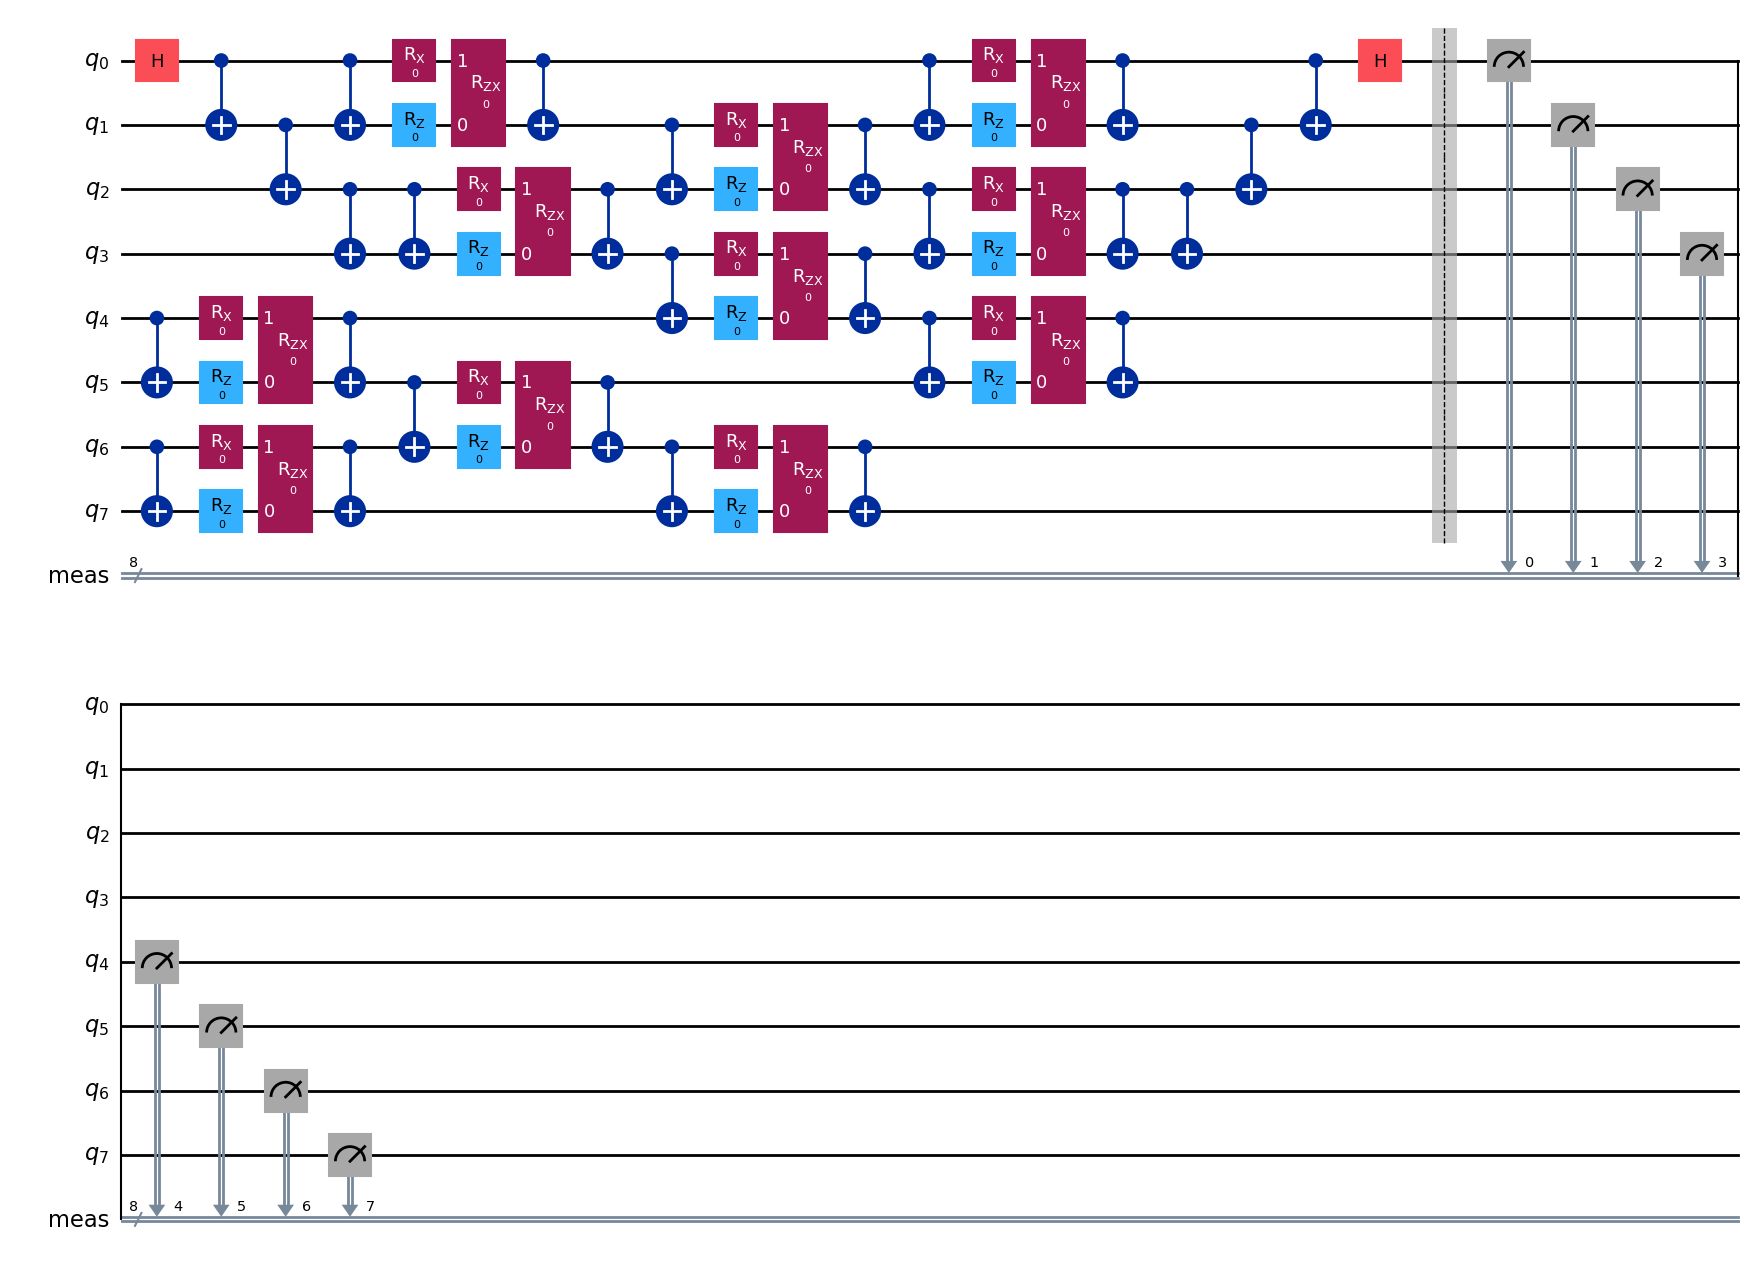

In [8]:
heisenberg_sim = HeisenbergModel(n_qubits, Js, backend_sim)
circuits = []
isa_circuits = []

for t in times:
    n_steps = get_n_steps(t)

    # For debug, we can get the circuit and ISA circuit from the simulator
    circuit, isa_circuit = heisenberg_sim.get_trotter_simulation_pub(
        t, n_steps, phase=0
    )
    # pass_managers.append(pm)
    circuits.append(circuit)
    isa_circuits.append(isa_circuit)

# Visualize original circuit
circuits[0].draw("mpl")

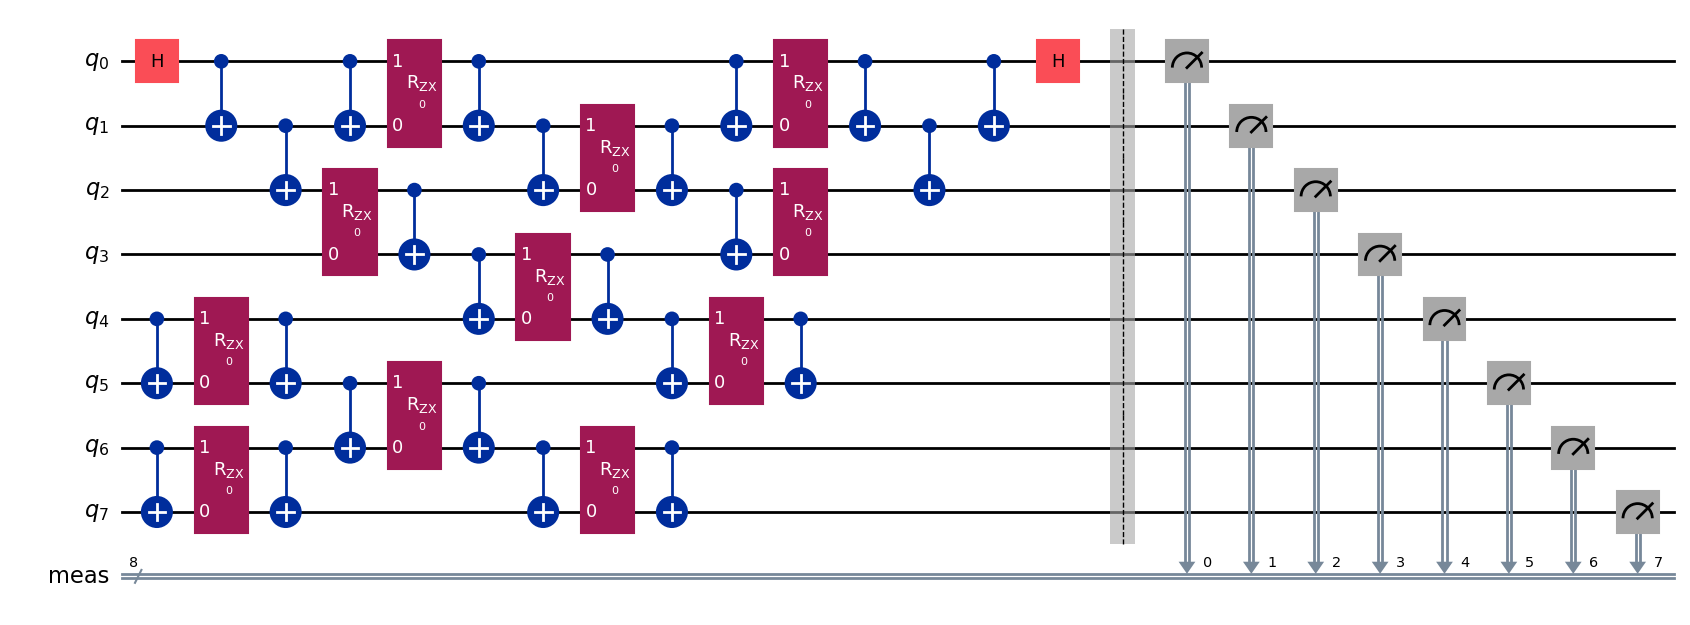

In [9]:
# Visualize transpiled circuit
isa_circuits[0].draw("mpl")

In [10]:
with Batch(backend=backend_sim):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 800ff190-864e-4e93-8a5f-b28d0271e0aa


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [11]:
# Post-processing
probs_sim = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim.append(prob0)

## Simulator (Noisy)

In [12]:
heisenberg_sim_noisy = HeisenbergModel(n_qubits, Js, backend_sim)
circuits = []
isa_circuits = []

for t in times:
    n_steps = get_n_steps(t)

    circuit, isa_circuit = heisenberg_sim_noisy.get_trotter_simulation_pub(
        t, n_steps, phase=0
    )
    circuits.append(circuit)
    isa_circuits.append(isa_circuit)

In [13]:
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 4dbb0046-c2e7-4f7e-b9d1-18622df75b11


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [14]:
# Post-processing
probs_sim_noisy = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim_noisy.append(prob0)

## QPU

In [15]:
heisenberg_qpu = HeisenbergModel(n_qubits, Js, backend_qpu)
circuits_qpu = []
isa_circuits_qpu = []

for t in times:
    n_steps = get_n_steps(t)

    circuit, isa_circuit = heisenberg_qpu.get_trotter_simulation_pub(
        t, n_steps, phase=0
    )
    circuits_qpu.append(circuit)
    isa_circuits_qpu.append(isa_circuit)

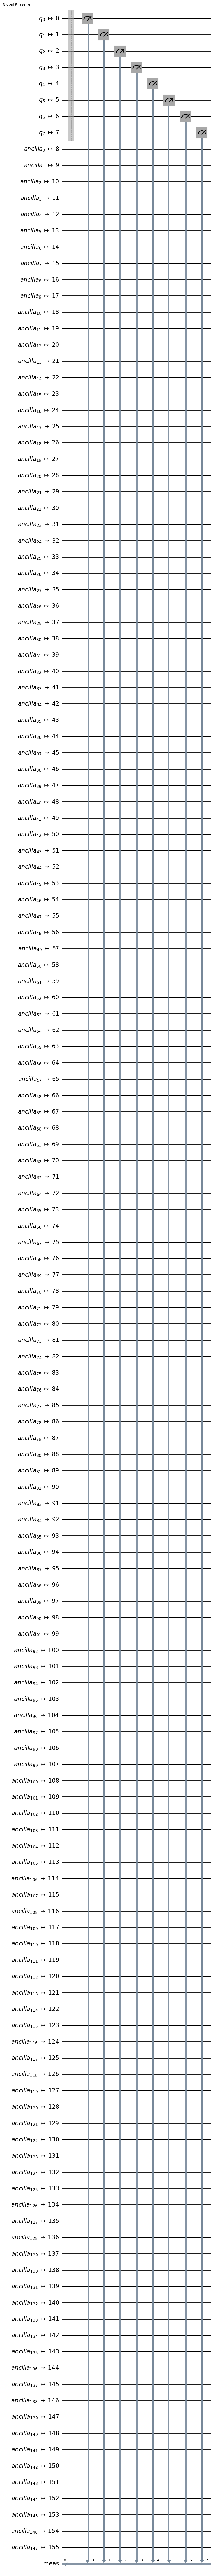

In [16]:
isa_circuits_qpu[0].draw("mpl")

In [ ]:
# Run a job in a batch
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits_qpu)
    print(f"job_id: {job.job_id()}")

In [ ]:
started_at = batch.details()["started_at"]
with open(f"./test_data/{current_time}/job_id_qpu.txt", "w") as f:
    f.write(job.job_id())
mit.cals_to_file(
    f"./test_data/{current_time}/calibrations_{backend_qpu.name}_{started_at}.json"
)

In [ ]:
# Retrieve the job
with open(f"./test_data/{current_time}/job_id_qpu.txt", "r") as f:
    job_id = f.read()

job = service.job(job_id)

In [ ]:
# Apply mititation
probs_qpu_nmit = []
probs_qpu_mit = []

cals_file = (
    f"./test_data/{current_time}/calibrations_{backend_qpu.name}_{started_at}.json"
)
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

for result in job.result():
    prob0_nmit, prob0_mit = get_prob0(result, n_qubits, mit)
    probs_qpu_nmit.append(prob0_nmit)
    probs_qpu_mit.append(prob0_mit)

In [ ]:
# Plot the results
plt.plot(times, probs_exact, label="exact")
plt.plot(times, probs_sim, label=f"Simulator, noise model: {backend_qpu.name}")
plt.plot(times, probs_qpu_nmit, label=f"QPU: {backend_qpu.name} (no mitigation)")
plt.plot(times, probs_qpu_mit, label=f"QPU: {backend_qpu.name} (with mitigation)")
plt.title(f"Heisenberg model with {n_qubits} qubits")
plt.ylim(0, 1.05)
plt.xlabel("Time")
plt.ylabel("Probability of $|0^n\\rangle$")
plt.legend()
plt.show()